## Загрузка и обзор данных

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.preprocessing
import joblib
import scipy
import mlflow
from implicit.als import AlternatingLeastSquares
import psycopg2 as psycopg
import os
import pickle

from catboost import CatBoostClassifier, Pool
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings("ignore")

In [4]:
RANDOM_STATE = 42
# Пути и названия файлов заданы в виде параметров
PATH_DATA = '../app/data'

PATH_MODELS = '../models'
MODEL_FILE = 'cb_model.pkl'

ASSETS_DIR = '../app/data/asserts'

TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000

EXPERIMENT_NAME = 'pr_final_#2'
REGISTRY_MODEL_NAME = "ranking_model"

In [5]:
# Загрузим первый датасет
category_tree = pd.read_csv(f'{PATH_DATA}/category_tree.csv')

In [6]:
# Выведем несколько строк
category_tree.head(3)

,categoryid,parentid
0,1016,213.0
1,809,169.0
2,570,9.0


In [7]:
# Выведем типы данных
category_tree.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1669 entries, 0 to 1668
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   categoryid  1669 non-null   int64  
 1   parentid    1644 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 26.2 KB


Датасет содержит два столбца: parentid - родительская категория и categoryid - дочерняя категория, которые представляют собой численные значения. Стобец parentid содержит пропуски.

In [5]:
# Посмотрим сгруппированный вариант данных
category_tree.groupby('parentid')['categoryid'].count().reset_index().sort_values('categoryid')

,parentid,categoryid
352,1671.0,1
349,1661.0,1
37,157.0,1
291,1394.0,1
294,1401.0,1
...,...,...
264,1259.0,18
77,351.0,19
215,1009.0,22
79,362.0,22


Каждому parentid может соотвествовать несколько categoryid.

In [6]:
# Посмотрим сгруппированный вариант данных
category_tree.groupby('categoryid')['parentid'].count().reset_index().sort_values('parentid')

,categoryid,parentid
1668,1698,0
1571,1600,0
1552,1579,0
1507,1532,0
1457,1482,0
...,...,...
40,40,1
1666,1696,1
1667,1697,1
1,1,1


Для каждого categoryid существует единственный parentid.

In [7]:
# Посмотрим пропущенные значения
category_tree[category_tree.isna().any(axis=1)]

,categoryid,parentid
5,231,NaN
589,791,NaN
861,1490,NaN
939,431,NaN
1111,755,NaN
1142,378,NaN
1208,1579,NaN
1211,1394,NaN
1322,659,NaN
1329,1057,NaN


Для небольшого количества categoryid нет parentid. Можно заполнить пропуски 0 - заглушкой.

In [8]:
# Проверим дубликаты
category_tree[category_tree.duplicated()]

,categoryid,parentid


Дублирующихся строк нет.

In [8]:
# Загрузим датасет в событиями
events = pd.read_csv(f'{PATH_DATA}/events.csv')

In [10]:
# Выведем несколько строк
events.head(3)

,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN


In [11]:
# Посмотрим на типы данных
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2756101 entries, 0 to 2756100
Data columns (total 5 columns):
 #   Column         Dtype  
---  ------         -----  
 0   timestamp      int64  
 1   visitorid      int64  
 2   event          object 
 3   itemid         int64  
 4   transactionid  float64
dtypes: float64(1), int64(3), object(1)
memory usage: 105.1+ MB


Датасет предствляет собой таблицу с логом событий. В ней содержатся как числовые, так и текстовые столбцы: timestamp — временная метка события visitorid — идентификатор пользователя, event — событие (просмотр, добавление в корзину, покупка - текстовые данные), itemid — идентификатор товара, transactionid — идентификатор транзакции (покупки).

In [12]:
# Посмотрим на данные с временными метками
print(events['timestamp'].min())
print(events['timestamp'].max())

1430622004384
1442545187788


Похоже, что в столбце 'timestamp' содержатся временные метки в миллисекундах с начала эпохи Unix (1 января 1970 года). Необходимо их преобразовать.

In [13]:
# Проверим дубликаты
events[events.duplicated()]

,timestamp,visitorid,event,itemid,transactionid
22404,1433180781440,1045411,addtocart,379647,NaN
34465,1433274223925,366538,addtocart,252068,NaN
39738,1433265100661,198153,addtocart,48715,NaN
41774,1433270868154,1268755,view,60980,NaN
42469,1433277134682,555487,addtocart,397642,NaN
...,...,...,...,...,...
2748964,1438346018813,722488,view,97303,NaN
2750464,1438370523152,896869,addtocart,85004,NaN
2752725,1438405570135,708442,addtocart,392883,NaN
2753763,1438376127329,372829,addtocart,388276,NaN


Дублтрующиеся строки можно удалить, поскольку повторение действий пользователем в одно и то же время маловероятно технически. В этом случае дубли - ошибка в данных.

In [14]:
# Проверим пропуски
events[events.isna().any(axis=1)]

,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN
3,1433221955914,483717,view,253185,NaN
4,1433221337106,951259,view,367447,NaN
...,...,...,...,...,...
2756096,1438398785939,591435,view,261427,NaN
2756097,1438399813142,762376,view,115946,NaN
2756098,1438397820527,1251746,view,78144,NaN
2756099,1438398530703,1184451,view,283392,NaN


Значения пропущены только в столбце transactionid в случае, когда покупка не была совершена.

In [15]:
# Посмотрим на типы событий для пропущенных 
events[events['transactionid'].isna()]['event'].unique()

array(['view', 'addtocart'], dtype=object)

In [16]:
# Посмотрим на типы событий для значениц без пропуска
events[~events['transactionid'].isna()]['event'].unique()

array(['transaction'], dtype=object)

В датасете events содержатся пропущенные значения в столбце transactionid и дублирующиеся строки. Дубликаты можно удалить, а столбец с транзакциями категоризовать и отсутствие факта покупки заполнить 0. В качестве таргета будем использовать факт добавления товара в корзину - событие addtocart.

In [17]:
# Загрузим датасет с товарами
item_1 = pd.read_csv(f'{PATH_DATA}/item_properties_part1.csv')

In [18]:
# Посмотрим на первые строки
item_1.head(3)

,timestamp,itemid,property,value
0,1435460400000,460429,categoryid,1338
1,1441508400000,206783,888,1116713 960601 n277.200
2,1439089200000,395014,400,n552.000 639502 n720.000 424566


In [19]:
# Посмотрим на типы данных
item_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999999 entries, 0 to 10999998
Data columns (total 4 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   timestamp  int64 
 1   itemid     int64 
 2   property   object
 3   value      object
dtypes: int64(2), object(2)
memory usage: 335.7+ MB


In [20]:
# Проверим пропуски
item_1[item_1.isna().any(axis=1)]

,timestamp,itemid,property,value


In [21]:
# Проверим дубликаты
item_1[item_1.duplicated()]

,timestamp,itemid,property,value


In [22]:
# Загрузим вторую часть данных
item_2 = pd.read_csv(f'{PATH_DATA}/item_properties_part2.csv')

In [23]:
item_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9275903 entries, 0 to 9275902
Data columns (total 4 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   timestamp  int64 
 1   itemid     int64 
 2   property   object
 3   value      object
dtypes: int64(2), object(2)
memory usage: 283.1+ MB


In [24]:
item_2[item_2.isna().any(axis=1)]

,timestamp,itemid,property,value


In [25]:
item_2[item_2.duplicated()]

,timestamp,itemid,property,value


Датасеты item_properties содержат информацию о товарах. Данные в столбцах представленых как в числовых, так и в текстовых форматах: timestamp - временная метка добавления свойства, itemid - идентификатор товара, property - свойство товара, value - значение свойства. В таблицах нет пропущенных значений и дублирующихся строк. Столбцы property и value содержат числовые и текстовые значения.

**Выводы**

Для построения сервиса рекомендотельной системы предоставляны три датасета: categor_tree с отношением категорий товаров, events с данными о взаимодействий пользователе с товарами и описание товаров в таблице items_property.

- Таблица category_tree содержит пропуски в столбце parentid - их можно заполнить.
- Таблица events содержит дубликаты (можно удалить) и пропуски (можно преобразовать). Также столбец event с значениями addtocard будет преобразован в таргет - факт добавления товара в корзину.
- Таблица в двух частях item_properties не содержит пропусков и дубликатов и представляет собой датасет с характеристиками товаров. Две части таблицы будут объединены.
- В таблицах таже необходимо преобразовать формат данных для лучшей интерпретируемости и анализа.

Центральная таблица events содержит id пользователей и их взаимодейвтия с товарами, в том числе и таргет. Для построения рекомендаций этих данных достаточно. Однако, для более точных рекомендаций по свойствам похожих товаров необхлдимо также добавить данные о товарах из таблицы item_properties. Таблица с категориями товаров также, возможно, будет полезной и даст дополнительные признаки.

## Предобработка данных

Выполним необходимые преобразования в таблице events.

In [26]:
# Заполним отсутствие транзакции 0 - покупка не совершена
events['transactionid'] = events['transactionid'].fillna(0).astype('int')

# Создадим новый признак - факт совершения покупки
events['istransaction'] = events['transactionid'].apply(lambda x: 0 if x==0 else 1).astype('int')

In [27]:
# Добавим в качестве таргета признак - добавления товара в корзину
events['target'] = events['event'].apply(lambda x: 1 if x=='addtocart' else 0)

In [28]:
# Преобразуем формат времени
events['timestamp'] = pd.to_datetime(events['timestamp'], unit='ms').dt.strftime('%Y-%m-%d %H:%M')

In [29]:
# Переименуем столбцы в более привычные для рекомендательных систем
events = events.rename(columns={'visitorid': 'user_id',
                                'itemid': 'item_id'})

In [30]:
# Проверим результат
events.sample(5)

,timestamp,user_id,event,item_id,transactionid,istransaction,target
1388950,2015-09-14 01:24,253321,view,283006,0,0,0
952008,2015-08-19 19:03,707483,view,269631,0,0,0
1857448,2015-05-21 23:50,773937,view,31928,0,0,0
2487107,2015-07-20 21:41,1211454,view,267489,0,0,0
2616060,2015-07-27 00:21,1366430,view,261663,0,0,0


In [31]:
# Сохраним обновленный датасет
events.to_csv(f'{PATH_DATA}/events_clean.csv', index=False)

Далее поработаем с данными о товарах.

In [32]:
# Объединим две части таблицы
items = pd.concat([item_1, item_2], axis=0)

In [33]:
# Преобразуем дату
items['timestamp'] = pd.to_datetime(items['timestamp'], unit='ms').dt.strftime('%Y-%m-%d %H:%M')

Проверим, не содержит ли таблица исторические данные с изменениями свойств товаров.

In [34]:
items.drop('timestamp', axis=1)[items.drop('timestamp', axis=1).duplicated()].sort_values('itemid')

,itemid,property,value
3200850,0,6,1152934 1238769
5586256,0,6,1152934 1238769
2803284,0,6,1152934 1238769
2604501,0,6,1152934 1238769
5785040,0,6,66094
...,...,...,...
3353490,466865,888,150169 780351 820477 437265 951705 1146011 115...
3552273,466865,888,150169 780351 820477 437265 951705 1146011 115...
2757141,466865,888,150169 780351 820477 437265 951705 1146011 115...
5341328,466865,888,150169 780351 820477 437265 951705 1146011 115...


Похоже, что изменения свойств товаров остались в датасете. Для построения рекомендательных систем эти данные бесполезны - знание о том, какая редакция карточки товара побудила совершить целевое действие, будут больше полезны для аналитического исследования.

In [35]:
# Остортируем датасет по времени и товарам
items = items.sort_values(['timestamp', 'itemid']).reset_index(drop=True)

In [36]:
# Посмотрим на результат
items.head(5)

,timestamp,itemid,property,value
0,2015-05-10 03:00,0,283,66094 372274 478989
1,2015-05-10 03:00,0,6,1152934 1238769
2,2015-05-10 03:00,0,159,519769
3,2015-05-10 03:00,0,678,372274
4,2015-05-10 03:00,0,790,n91200.000


In [37]:
# Удалим дубликаты, оставив только последнюю по времени строку со свойствами
items = items.drop_duplicates(['itemid','property','value'], keep='last').reset_index(drop=True)

In [38]:
# Посмотрим на результат
items.head(10)

,timestamp,itemid,property,value
0,2015-05-10 03:00,0,283,66094 372274 478989
1,2015-05-10 03:00,0,159,519769
2,2015-05-10 03:00,0,678,372274
3,2015-05-10 03:00,0,790,n91200.000
4,2015-05-10 03:00,0,categoryid,209
5,2015-05-10 03:00,1,available,1
6,2015-05-10 03:00,1,776,379040
7,2015-05-10 03:00,1,categoryid,1114
8,2015-05-10 03:00,1,112,679677
9,2015-05-10 03:00,1,159,519769


In [39]:
# Переименуем столбец
items = items.rename(columns={'itemid': 'item_id'})

In [40]:
# Сохраним полученный датасет
items.to_csv(f'{PATH_DATA}/items_clean.csv', index=False)

## EDA

In [9]:
events = pd.read_csv(f'{PATH_DATA}/events_clean.csv', index_col=False)

In [6]:
# Преобразуем формат данных
events['timestamp'] = pd.to_datetime(events['timestamp'])

# Извлекаем день недели и час
events['day_of_week'] = events['timestamp'].dt.dayofweek  # Получаем день недели
events['day'] = events['timestamp'].dt.day  # Получаем день в месяце
events['hour'] = events['timestamp'].dt.hour  # Получаем час

In [7]:
# Получим датасет с количество пользователей и событий по дням недели
events_by_day_week = events.groupby("day_of_week").agg(events=("day_of_week", "count"), 
                                                    users=("user_id", "nunique")).reset_index()

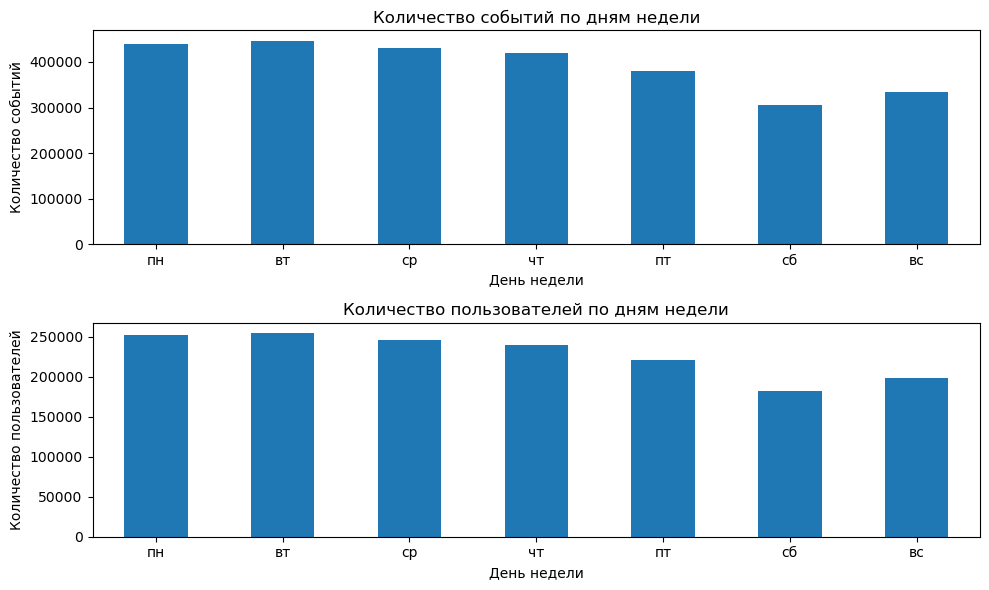

In [14]:
# Построим распределение событий по дням недели

fig, axs = plt.subplots(2, 1, figsize=(10, 6))

ax = axs[0]
events_by_day_week["events"].plot(kind="bar", ax=ax)
ax.set_title('Количество событий по дням недели')
ax.set_xticklabels(['пн', 'вт', 'ср', 'чт', 'пт', 'сб', 'вс'], rotation=0)
ax.tick_params(axis='x', labelsize=10)
ax.set_xlabel('День недели')
ax.set_ylabel('Количество событий')

ax = axs[1]
events_by_day_week["users"].plot(kind="bar", ax=ax)
ax.set_title('Количество пользователей по дням недели')
#ax.set_xticklabels(events_by_day['day_of_week'], rotation=45)
ax.set_xticklabels(['пн', 'вт', 'ср', 'чт', 'пт', 'сб', 'вс'], rotation=0)
ax.tick_params(axis='x', labelsize=10)
ax.set_xlabel('День недели')
ax.set_ylabel('Количество пользователей')

fig.tight_layout()

Количество пользователей и взаимодействий с оварами меняется в течение недели. Можно сказать, что максимальное количество взаимодействий происходит в первой половине недели и минимально по субботам.

In [16]:
# Получим датасет с количество пользователей и событий по дням
events_by_day = events.groupby("day").agg(events=("day", "count"), 
                                          users=("user_id", "nunique")).reset_index()

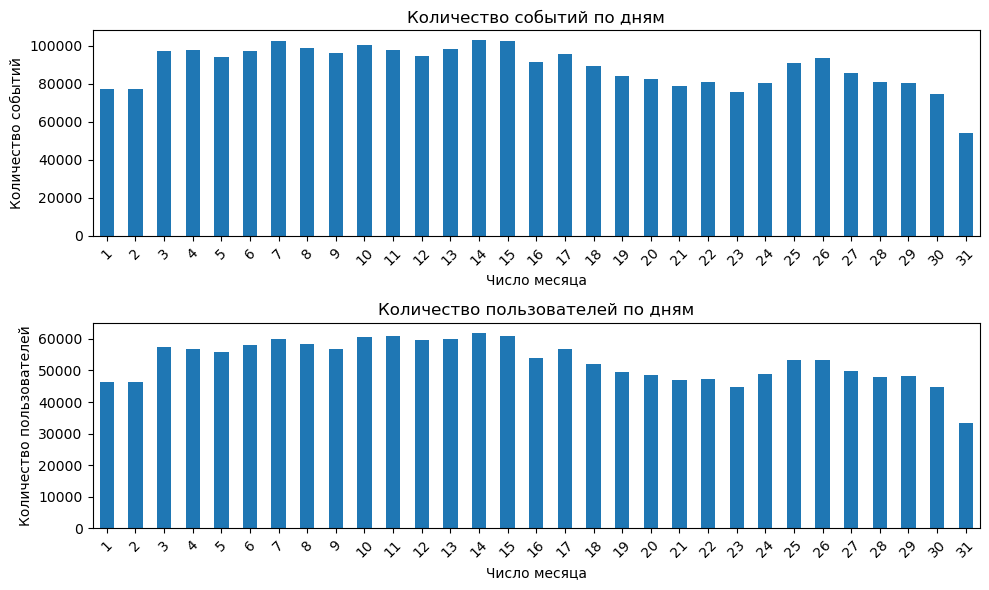

In [17]:
# Построим распределение событий по дням недели

fig, axs = plt.subplots(2, 1, figsize=(10, 6))

ax = axs[0]
events_by_day["events"].plot(kind="bar", ax=ax)
ax.set_title('Количество событий по дням')
ax.set_xticklabels(events_by_day['day'], rotation=45)
ax.tick_params(axis='x', labelsize=10)
ax.set_xlabel('Число месяца')
ax.set_ylabel('Количество событий')

ax = axs[1]
events_by_day["users"].plot(kind="bar", ax=ax)
ax.set_title('Количество пользователей по дням')
ax.set_xticklabels(events_by_day['day'], rotation=45)
ax.tick_params(axis='x', labelsize=10)
ax.set_xlabel('Число месяца')
ax.set_ylabel('Количество пользователей')

fig.tight_layout()

Количество пользователей и взаимодействий с товарами меняется в течение месяца. К середине месяца количество взаимодействий увеличивается, потом снижается и новый пик к концу месяца.

In [18]:
# Получим датасет с количество пользователей и событий по дням
events_hour = events.groupby("hour").agg(events=("hour", "count"), 
                                          users=("user_id", "nunique")).reset_index()

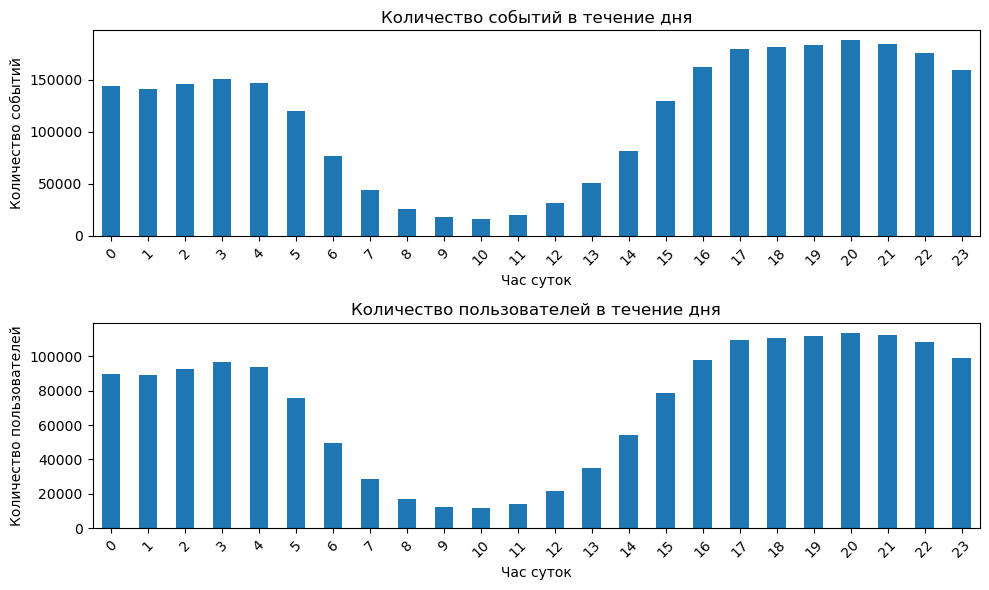

In [20]:
# Построим распределение событий по часам в течение дня

fig, axs = plt.subplots(2, 1, figsize=(10, 6))

ax = axs[0]
events_hour["events"].plot(kind="bar", ax=ax)
ax.set_title('Количество событий в течение дня')
ax.set_xticklabels(events_hour['hour'], rotation=45)
ax.tick_params(axis='x', labelsize=10)
ax.set_xlabel('Час суток')
ax.set_ylabel('Количество событий')

ax = axs[1]
events_hour["users"].plot(kind="bar", ax=ax)
ax.set_title('Количество пользователей в течение дня')
ax.set_xticklabels(events_hour['hour'], rotation=45)
ax.tick_params(axis='x', labelsize=10)
ax.set_xlabel('Час суток')
ax.set_ylabel('Количество пользователей')

fig.tight_layout()

В течение дня суммарное количество взаимодействий и пользователей сильно меняется. Возможно, это связано с разными часовыми поясами пользователей, эта информация в данных отсуствует. Однако, можно сделать вывод по имеющимся данным, что в утренние часы количество взимодействий минимально.

event
view           2664312
addtocart        69332
transaction      22457
Name: count, dtype: int64


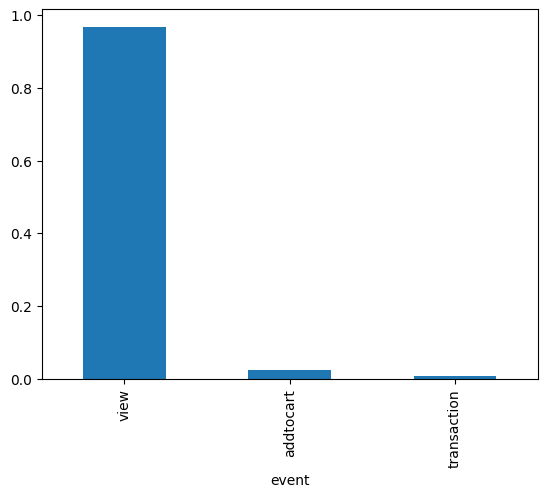

In [49]:
#выведем относительное количество данных в двух классах
print(events['event'].value_counts())

events['event'].value_counts(normalize=True).plot(kind='bar');

Ожидаемо, пользователи чаще всего просто смотрят товары, не совершая целевое действие - добавление в корзину. 

In [50]:
# Посмотрим на распределение таргета
print(events['target'].value_counts(normalize=True))

target
0    0.974844
1    0.025156
Name: proportion, dtype: float64


В дальнейшем проблему дисбаланса необходимо решить для корректного построения рекомендаций. Далее посмотрим, как в среднем пользователи взаимодействуют с товарами.

In [51]:
# Среднее количество взаимодействий по пользователям за весь период
average_events_per_user = events.groupby('user_id').size().mean()
print(f'Среднее количество взаимодействий на пользователя: {round(average_events_per_user, 2)}')

Среднее количество взаимодействий на пользователя: 1.96


In [52]:
# Среднее количество целевых действий по пользователям за весь период
average_events_per_user = events[events['target']==1].groupby('user_id').size().mean()
print(f'Среднее количество целевых действий на пользователя: {round(average_events_per_user, 2)}')

Среднее количество целевых действий на пользователя: 1.84


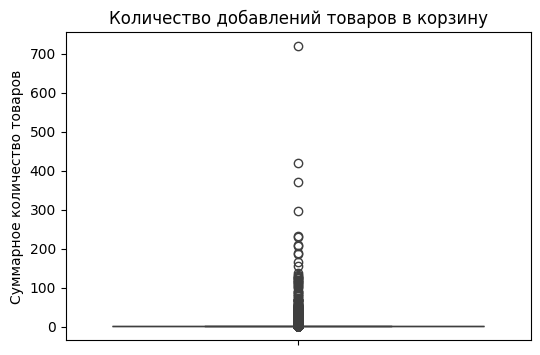

In [53]:
# В отдельной таблице посчитаем суммарное количество прослушанных треков
target_boxplot = events[events['target']==1].groupby('user_id').agg(item_count = ('item_id', 'count')).reset_index(drop=True)

# Создание графика
plt.figure(figsize=(6, 4))
sns.boxplot(data=target_boxplot['item_count'])

# Настройка заголовка и осей
plt.title('Количество добавлений товаров в корзину')
plt.ylabel('Суммарное количество товаров')

plt.show()

Можно заметить, что разброс значений достаточно большой. Чаще всего пользователи добавляют по одному товару в корзину.

In [54]:
# Посмотрим на распределение по квантилям
target_boxplot.describe()

,item_count
count,37722.000000
mean,1.837973
std,6.882063
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,719.000000


Распределение количества целевых действий по пользовтелям имеет длинный "хвост" - распределение смещено к значению 1 (добавление одного товара в корзину одним пользователем). Встречаются также очень большые значения от 100 до 700 добавлений товаров в корзину одни пользователем. Поскольку физически такое поведение пользователя возможно, удалять выбросы не будем.

In [55]:
# Далее посмотрим на топ популярных товаров
top_10_items = events.groupby('item_id').agg(user_id_count = ('user_id', 'nunique'))\
                                                .sort_values('user_id_count', ascending=False)\
                                                .reset_index().head(10)

In [56]:
# Посмотрим на id товаров
top_10_items

,item_id,user_id_count
0,187946,2912
1,5411,2079
2,370653,1577
3,461686,1393
4,219512,1370
5,96924,1359
6,298009,1342
7,335975,1154
8,384302,1154
9,151444,1103


Поскольку расшифровки нет, невозможно понять, какие товары самые популярные. Однако можно заметить, что среди популярных товаров разброс числа пользователей, повзаимодействовавших (просмотренных, поскольку данный тип событий преобладает) с товаров распределен равномерно.

In [57]:
# Далее посмотрим на топ популярных товаров, которые были добавлены в корзину
top_10_items_target = events[events['target']==1].groupby('item_id').agg(user_id_count = ('user_id', 'nunique'))\
                                                 .sort_values('user_id_count', ascending=False)\
                                                 .reset_index().head(10)

In [58]:
# Посмотрим на id товаров
top_10_items_target

,item_id,user_id_count
0,461686,267
1,320130,131
2,312728,129
3,409804,128
4,29196,101
5,7943,87
6,48030,85
7,441852,82
8,445351,80
9,257040,79


Можно заметить, что топ просмотренных и топ добавленных в корзину товаров не совпадает (только один товар совпал с id 461686). Далее добавим к взаимодействиям свойства товаров.

In [60]:
# Посмотрим на поплуряные признаки товаров
items.groupby('property')['item_id'].count().sort_values(ascending=False).head(20)

property
790           758982
888           576145
available     484054
categoryid    442432
283           428643
6             422256
678           420884
364           420568
776           417337
764           417053
159           417053
112           417053
202           416446
917           416235
839           398013
227           329360
698           275717
689           211971
28            170106
928           150838
Name: item_id, dtype: int64

In [61]:
# Посмотрим на значения свойств для случайного товара
items[items['item_id']==59481].drop_duplicates(subset=['property', 'value'])

,timestamp,item_id,property,value
340657,2015-05-10 03:00,59481,available,1
340658,2015-05-10 03:00,59481,1032,769062
340659,2015-05-10 03:00,59481,764,1285872
2756932,2015-05-17 03:00,59481,678,367680
2756933,2015-05-17 03:00,59481,776,819423
3495069,2015-05-24 03:00,59481,6,125236
3495070,2015-05-24 03:00,59481,839,367680
3495071,2015-05-24 03:00,59481,178,769062
3495072,2015-05-24 03:00,59481,227,125236
4957031,2015-05-31 03:00,59481,431,341968


Непонятно, если среди признаков какой-то рейтинг или цена. Можно выделить признаки, значения которых есть для всех товаров и далее использовать их для построения рекомендаций. Вынесем их в отдельный список.

In [62]:
pr = ['790',          
'888',         
'available', 
'categoryid',    
'283',     
'6',     
'678',  
'364', 
'776',    
'764',    
'159',   
'112']

print(f"Количество уникальных товаров с выбранными признакми: {items[items['property'].isin(pr)]['item_id'].nunique()}")
print(f"Количество уникальных товаров: {items['item_id'].nunique()}")

Количество уникальных товаров с выбранными признакми: 417053
Количество уникальных товаров: 417053


Далее вынесем отобранные признаки в отдельные столбцы.

In [63]:
# Вынесем отдельно список с популярными своцствами товаров
pr = ['available', 'categoryid', '790', '888', '283', '6', '678', '364', '776', '764', '159', '112']

# Создание списка для хранения новых DataFrame
dfs = []

# Проходим по каждому элементу из списка pr
for prop in pr:
    # Фильтруем DataFrame items по свойству
    filtered_items = items[items['property'] == prop].rename(columns={'value': prop}).reset_index(drop=True)
    filtered_items = filtered_items[['item_id', prop]]
    dfs.append(filtered_items)

# Объединяем все DataFrame в один, оставим последнее по дате изменение
items_top_properties = pd.concat(dfs, axis=0).groupby('item_id', as_index=False).last()

In [64]:
# Проверим пропуски
items_top_properties.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 417053 entries, 0 to 417052
Data columns (total 13 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   item_id     417053 non-null  int64 
 1   available   417053 non-null  object
 2   categoryid  417053 non-null  object
 3   790         417053 non-null  object
 4   888         417053 non-null  object
 5   283         417053 non-null  object
 6   6           409065 non-null  object
 7   678         417019 non-null  object
 8   364         417053 non-null  object
 9   776         407305 non-null  object
 10  764         417053 non-null  object
 11  159         417053 non-null  object
 12  112         417053 non-null  object
dtypes: int64(1), object(12)
memory usage: 41.4+ MB


Некоторые признаки остались незаполненными, пока оставим как есть. Далее добавим отобранные свойства к датасету с взаимодействиями.

In [65]:
# Проверим, для всех ли товаров из датасета с взаимодействиями есть свойства товаров
items_list = items_top_properties['item_id'].unique()

print(f"Количество строк с взаимодействиями: {events.shape[0]}")
print(f"Количество строк без описаний товаров: {events[~events['item_id'].isin(items_list)].shape[0]}")

Количество строк с взаимодействиями: 2756101
Количество строк без описаний товаров: 255585


Примерно 10% строк останется без признаков со свойствами товаров. Необходимо их удалить.

In [66]:
# Удалим товары без свойств
events = events[events['item_id'].isin(items_list)].reset_index(drop=True)

In [67]:
# Присоединим признаки
events_prop = events.merge(items_top_properties, on='item_id', how='left')

In [68]:
# Посмотрим на результат
events_prop.sample(3)

,timestamp,user_id,event,item_id,transactionid,istransaction,target,day_of_week,day,hour,...,790,888,283,6,678,364,776,764,159,112
1834477,2015-05-30 03:21:00,415305,view,203201,0,0,0,5,30,3,...,n2760.000,821488,868402 1016879 1205306 1275486 821488 1016879 ...,868402 1016879,1205306 1275486,975468,729364,1285872,519769,679677
533694,2015-06-29 17:42:00,1150086,view,324290,0,0,0,0,29,17,...,n7320.000,429862 n3600.000 504419,639021 763949 429862 n3600.000 504419 763949 8...,639021,763949,409983,989192,1285872,519769,679677
2255268,2015-07-21 03:37:00,1237699,view,172894,0,0,0,1,21,3,...,n36240.000,1084196 1328698 206386,668584 65390 1084196 1328698 668584 65390 9766...,668584,65390,134,516501,1285872,519769,679677


In [69]:
# Теперь можно присоединить датасет category_tree

# Заполним категорию 0
events_prop['categoryid'] = events_prop['categoryid'].fillna('0')

# Преобразуем тип данных
events_prop['categoryid'] = events_prop['categoryid'].astype('int')

events_prop = events_prop.merge(category_tree, on='categoryid', how='left')

Создадим собственный признак-рейтинг на основе частоты взаимодействий пользователей с товаром.

In [70]:
# Подсчет всех user_id с учетом просмотров и покупок
events_prop['rating_count'] = events_prop.groupby('item_id')['user_id'].transform('count')

# Отмасштабируем признак, чтобы оценки были в одной шкале
scaler = MinMaxScaler()

events_prop['rating'] = scaler.fit_transform(events_prop[['rating_count']])

Полученные признаки больше похожи на эмбеддинги и требуют особой обработки. Если же попытаться категоризовать получившиеся признаки в привычную матрицу, столбцов получится слишком много. Поэтому ограничимся нексколькими признаками.

In [71]:
# Отберем необходимые признаки
selected_columns = ['timestamp',
                    'user_id',
                    'item_id',
                    'available',
                    'categoryid',
                    'parentid',
                    'istransaction',
                    'day_of_week',
                    'day',
                    'hour',
                    'rating',
                    'target']

# Создадим итоговый датасет
events_df = events_prop[selected_columns]

Признак event тоже нет необходимости сохрянять, поскольку добавление в корзину отмечено в отдельном признаке - target, а покупка в istransaction, таким образом, все остальное - просмотры.  

In [72]:
# Посмотрим на итоговый датасет
events_df.head(5)

,timestamp,user_id,item_id,available,categoryid,parentid,istransaction,day_of_week,day,hour,rating,target
0,2015-06-02 05:02:00,257597,355908,1,1173,805.0,0,1,2,5,0.016417,0
1,2015-06-02 05:50:00,992329,248676,1,1231,901.0,0,1,2,5,0.009675,0
2,2015-06-02 05:12:00,483717,253185,0,914,226.0,0,1,2,5,0.003811,0
3,2015-06-02 05:02:00,951259,367447,0,491,679.0,0,1,2,5,0.075931,0
4,2015-06-02 05:48:00,972639,22556,0,1074,339.0,0,1,2,5,0.000586,0


In [73]:
# Выведем топ-10 товаров по рейтингу
events_df.drop_duplicates(subset='item_id').sort_values('rating', ascending=False).head(10)

,timestamp,user_id,item_id,available,categoryid,parentid,istransaction,day_of_week,day,hour,rating,target
68296,2015-06-04 21:32:00,244230,187946,0,1393,1383.0,0,3,4,21,1.000000,0
5163,2015-06-01 17:23:00,1026179,461686,1,1037,402.0,0,0,1,17,0.872765,0
3096,2015-06-02 03:41:00,615875,5411,1,789,14.0,0,1,2,3,0.683964,0
1280,2015-06-01 13:07:00,1260217,370653,0,82,1125.0,0,0,1,13,0.543242,0
3413,2015-06-01 19:41:00,71037,219512,1,5,1637.0,0,0,1,19,0.527411,0
260,2015-06-01 21:22:00,463621,257040,0,683,1606.0,0,0,1,21,0.482556,0
1470,2015-06-01 17:24:00,24919,298009,0,529,623.0,0,0,1,17,0.481091,0
247,2015-06-01 20:58:00,945697,96924,0,56,1497.0,0,0,1,20,0.478452,0
2216,2015-06-01 20:33:00,645651,309778,0,683,1606.0,0,0,1,20,0.476986,0
7221,2015-06-01 19:44:00,1135594,384302,1,5,1637.0,0,0,1,19,0.471123,0


In [74]:
# Выведем топ по рейтингу среди купленных товаров
events_df[events_df['target']==1].drop_duplicates(subset='item_id').sort_values('rating', ascending=False).head(10)

,timestamp,user_id,item_id,available,categoryid,parentid,istransaction,day_of_week,day,hour,rating,target
551503,2015-06-30 19:06:00,755375,187946,0,1393,1383.0,0,1,30,19,1.000000,1
57104,2015-06-04 04:26:00,1259098,461686,1,1037,402.0,0,3,4,4,0.872765,1
164324,2015-06-09 19:52:00,72742,5411,1,789,14.0,0,1,9,19,0.683964,1
377840,2015-06-22 05:27:00,289539,219512,1,5,1637.0,0,0,22,5,0.527411,1
86391,2015-06-05 21:07:00,390314,257040,0,683,1606.0,0,4,5,21,0.482556,1
46494,2015-06-04 02:25:00,280585,309778,0,683,1606.0,0,3,4,2,0.476986,1
143033,2015-06-09 04:06:00,749353,384302,1,5,1637.0,0,1,9,4,0.471123,1
72450,2015-06-05 04:37:00,283323,320130,1,1483,561.0,0,4,5,4,0.441513,1
7713,2015-06-01 23:38:00,319880,7943,1,398,1323.0,0,0,1,23,0.436236,1
428,2015-06-02 04:19:00,168685,111530,1,1625,1141.0,0,1,2,4,0.423923,1


Товары частично повторяются в двух таблицах с топ-10 товаров. 

In [76]:
# Заполним пропуски 0
events_df = events_df.fillna(0)

In [77]:
# Сохраним результат
events_df.to_csv(f'{PATH_DATA}/events_final.csv', index=False)

## Выводы по EDA

### Выводы:
1. Взаимодействия пользователей с товарами имеют выраженную временную динамику. В течение недели наблюдается пик взаимодействий в первой половине, с минимальными показателями по субботам. В месячном разрезе количество взаимодействий увеличивается к середине месяца, достигает максимума в конце месяца, после чего происходит снижение.

2. В течение дня количество взаимодействий значительно варьируется, с минимальным уровнем в утренние часы. Это может быть связано с разными часовыми поясами пользователей, что требует дальнейшего изучения.

3. Пользователи в основном просматривают товары, не совершая целевых действий - добавление в корзину. Это свидетельствует о необходимости решения проблемы дисбаланса для более эффективного построения рекомендаций.

4. Среднее число добавленных товаров на пользователя невелико, однако распределение имеет длинный "хвост", где наблюдаются значительные выбросы (от 100 до 700 добавлений). Это поведение может быть реальным и требует дальнейшего анализа.

5. Топ просмотренных и топ добавленных в корзину товаров не совпадают, что указывает на различия в интересах пользователей и их поведении. Один товар совпадает в обеих категориях (id 461686). Неясно, какие именно товары являются самыми популярными, поскольку отсутствуют характеристики товаров, такие как рейтинг или цена.

6. Признаки, содержащиеся в данных, выглядят как эмбеддинги и требуют специальной обработки. При попытке категоризовать их в привычную матрицу может возникнуть проблема с количеством столбцов.

7. Необходимо отказаться от сохранения признака event, так как целевые действия уже обозначены в отдельных признаках (target и istransaction).

8. Около 10% строк данных останется без признаков, что может ограничить возможности анализа. Это требует привлечения дополнительных данных или методов для характеристики товаров.

### Гипотезы:
1.  Повышенная активность пользователей в начале недели может быть связана с началом новых акций или обновлений товаров.
2. Утренние часы имеют низкий уровень взаимодействий из-за занятости пользователей, в то время как вечерние часы могут быть более активными.
3. Низкий уровень добавлений в корзину может быть связан с недостаточной привлекательностью товаров или сложностью процесса покупки.
4. Высокая активность некоторых пользователей может быть связана с их статусом или интересами, что требует дальнейшего изучения их поведения.
5. Товары, которые часто просматриваются, могут иметь привлекательные визуальные характеристики, но не удовлетворяют потребностям пользователей, что приводит к низкому уровню добавлений в корзину.

## Разбиение данных

In [6]:
# Загружаем данные
events = pd.read_csv(f'{PATH_DATA}/events_final.csv')
items = pd.read_csv(f'{PATH_DATA}/items_clean.csv')

In [5]:
events['timestamp'] = pd.to_datetime(events['timestamp'], errors='coerce')

# Зададим точку разбиения
train_test_global_time_split_date = pd.to_datetime("2015-09-01 00:00:00")

# Фильтрация данных на основе условия
train_test_global_time_split_idx = events["timestamp"] < train_test_global_time_split_date
events_train = events[train_test_global_time_split_idx]
events_test = events[~train_test_global_time_split_idx]

print(events_train.shape, events_test.shape)

(2227265, 12) (273251, 12)


В тесте остаются взаимодействия за один день - примерно 10% данных.

In [6]:
# количество пользователей в train и test
users_train = events_train["user_id"].drop_duplicates()
users_test = events_test["user_id"].drop_duplicates()

In [7]:
# Количество пользователей, которые есть и в train, и в test
common_users = set(users_train).intersection(set(users_test))

print(len(users_train), len(users_test), len(common_users))

1098320 152339 14627


In [8]:
# Холодные пользователи. Те кто есть в тест, но нет в трейн
cold_users = users_test[~users_test.isin(common_users)]

print(len(cold_users))

137712


In [83]:
# Сохраним холодных пользователей
cold_users.to_csv(f'{PATH_DATA}/cold_users.csv', index=False)

In [9]:
# Перекодируем идентификаторы пользователей в последовательность с 0
user_encoder = sklearn.preprocessing.LabelEncoder()
user_encoder.fit(events["user_id"])

events["user_id_enc"] = user_encoder.transform(events["user_id"])
events_train["user_id_enc"] = user_encoder.transform(events_train["user_id"])
events_test["user_id_enc"] = user_encoder.transform(events_test["user_id"])

In [10]:
# Перекодируем идентификаторы объектов в последовательность с 0
item_encoder = sklearn.preprocessing.LabelEncoder()
item_encoder.fit(items["item_id"])

items["item_id_enc"] = item_encoder.transform(items["item_id"])
events_train["item_id_enc"] = item_encoder.transform(events_train["item_id"])
events_test["item_id_enc"] = item_encoder.transform(events_test["item_id"])

In [11]:
# Перекодируем идентификаторы категории в последовательность с 0
category_encoder = sklearn.preprocessing.LabelEncoder()
category_encoder.fit(events["categoryid"])

events["categoryid_enc"] = category_encoder.transform(events["categoryid"])
events_train["categoryid_enc"] = category_encoder.transform(events_train["categoryid"])
events_test["categoryid_enc"] = category_encoder.transform(events_test["categoryid"])

In [12]:
# Перекодируем идентификаторы категории в последовательность с 0
parent_encoder = sklearn.preprocessing.LabelEncoder()
parent_encoder.fit(events["parentid"])

events["parentid_enc"] = parent_encoder.transform(events["parentid"])
events_train["parentid_enc"] = parent_encoder.transform(events_train["parentid"])
events_test["parentid_enc"] = parent_encoder.transform(events_test["parentid"])

In [96]:
# Сохраним кодировщики
joblib.dump(user_encoder, f'{PATH_DATA}/user_encoder.pkl')
joblib.dump(item_encoder, f'{PATH_DATA}/item_encoder.pkl')
joblib.dump(category_encoder, f'{PATH_DATA}/category_encoder.pkl')
joblib.dump(parent_encoder, f'{PATH_DATA}/parent_encoder.pkl')

['../data/parent_encoder.pkl']

In [119]:
RUN_NAME = 'recsys_encoders'

os.environ["MLFLOW_S3_ENDPOINT_URL"] = "https://storage.yandexcloud.net" 
os.environ["AWS_ACCESS_KEY_ID"] = os.getenv("AWS_ACCESS_KEY_ID") 
os.environ["AWS_SECRET_ACCESS_KEY"] = os.getenv("AWS_SECRET_ACCESS_KEY")

mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")

# В первый раз создадим эксперимент
experiment_id = mlflow.create_experiment(EXPERIMENT_NAME)
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id

    mlflow.log_metric('train_size', events_train.shape[0])
    mlflow.log_metric('test_size', events_test.shape[0])
    mlflow.log_params({"features": events_test.columns.to_list()})

    joblib.dump(user_encoder, "user_encoder.pkl")
    mlflow.log_artifact("user_encoder.pkl")

    joblib.dump(item_encoder, "item_encoder.pkl")
    mlflow.log_artifact("item_encoder.pkl")

    joblib.dump(category_encoder, "category_encoder.pkl")
    mlflow.log_artifact("category_encoder.pkl")

    joblib.dump(parent_encoder, "parent_encoder.pkl")
    mlflow.log_artifact("parent_encoder.pkl")


In [99]:
# Проверим результат кодирования
display(events_train[events_train['item_id']==248676].head(3))
display(events_test[events_test['item_id']==248676].head(3))

,timestamp,user_id,item_id,available,categoryid,parentid,istransaction,day_of_week,day,hour,rating,target,user_id_enc,item_id_enc,categoryid_enc,parentid_enc
1,2015-06-02 05:50:00,992329,248676,1,1231,901.0,0,1,2,5,0.009675,0,871317,222201,791,144
155836,2015-06-09 20:07:00,1356496,248676,1,1231,901.0,0,1,9,20,0.009675,1,1191177,222201,791,144
159801,2015-06-09 20:15:00,1356496,248676,1,1231,901.0,0,1,9,20,0.009675,0,1191177,222201,791,144


,timestamp,user_id,item_id,available,categoryid,parentid,istransaction,day_of_week,day,hour,rating,target,user_id_enc,item_id_enc,categoryid_enc,parentid_enc
1075255,2015-09-02 20:29:00,711786,248676,1,1231,901.0,0,2,2,20,0.009675,0,625002,222201,791,144


In [100]:
# Сохраним датасеты
events_train.to_csv(f'{PATH_DATA}/events_train.csv', index=False)
events_test.to_csv(f'{PATH_DATA}/events_test.csv', index=False)

## Рекомендации по умолчанию

Создадим рекомендации для новых пользователей. В качестве рекомендаций будем использовать топ 50 популярных товаров по взаимодействиям среди покупателей.

In [7]:
events_train = pd.read_csv(f'{PATH_DATA}/events_train.csv', index_col=False)
events_test = pd.read_csv(f'{PATH_DATA}/events_test.csv', index_col=False)

In [30]:
# Посчитаем количество прослушиваний уникальными пользователями
item_popularity = events_train \
    .groupby(["item_id"]).agg(users=("user_id", "nunique"), avg_rating=("rating", "mean")).reset_index()

# Добавляем информацию о треках
top_k_pop_items = item_popularity.sort_values('users', ascending=False).head(50)

In [31]:
# Добавляем новый столбец с порядковым номером строки - ранжированием
top_k_pop_items['rank'] = range(1, len(top_k_pop_items) + 1)

В других датасетах нет каких либо расшифровок, плэтому добалять инфорацию о товарах нет смысла.

In [87]:
# Сохраним результат
top_k_pop_items.to_parquet("../app/recommendations/top_popular.parquet", engine='pyarrow')

In [120]:
RUN_NAME = 'recsys_top_popular_recs'

os.environ["MLFLOW_S3_ENDPOINT_URL"] = "https://storage.yandexcloud.net" 
os.environ["AWS_ACCESS_KEY_ID"] = os.getenv("AWS_ACCESS_KEY_ID") 
os.environ["AWS_SECRET_ACCESS_KEY"] = os.getenv("AWS_SECRET_ACCESS_KEY")

mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")

experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

parquet_file_path = "top_popular.parquet"
top_k_pop_items.to_parquet(parquet_file_path, engine='pyarrow')

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id

    mlflow.log_artifact(parquet_file_path)

## Персональные рекомендации

Рассчитаем персональные рекомендации. Обучим бустинговую модель на таргет 1 и 0 - добавление в товара в корзину и дале проранжируем рекомендации.

In [8]:
# Загрузим данные
events_train = pd.read_csv(f'{PATH_DATA}/events_train.csv', index_col=False)
events_test = pd.read_csv(f'{PATH_DATA}/events_test.csv', index_col=False)
items = pd.read_csv(f'{PATH_DATA}/items_clean.csv', index_col=False)
events = pd.read_csv(f'{PATH_DATA}/events_final.csv')

item_encoder = joblib.load(f'{PATH_DATA}/item_encoder.pkl')
user_encoder = joblib.load(f'{PATH_DATA}/user_encoder.pkl')

In [9]:
# Преобразуем формат времени
events_train['timestamp'] = pd.to_datetime(events_train['timestamp'])
events_test['timestamp'] = pd.to_datetime(events_test['timestamp'])
events['timestamp'] = pd.to_datetime(events['timestamp'])

Рассчитаем похожите товары, это необходимо для построения онлайн-рекомендаций.

In [10]:
# Создаём sparse-матрицу формата CSR 
user_item_matrix_train = scipy.sparse.csr_matrix((
    events_train["rating"],
    (events_train['user_id_enc'], events_train['item_id_enc'])),
    dtype=np.int8) 

user_item_matrix_train

<Compressed Sparse Row sparse matrix of dtype 'int8'
	with 1711166 stored elements and shape (1236032, 417051)>

In [11]:
# Создадим модель ALS
als_model = AlternatingLeastSquares(factors=50, 
                                    iterations=50, 
                                    regularization=0.05, 
                                    random_state=RANDOM_STATE)

# Обучим модель ALS
als_model.fit(user_item_matrix_train)

100%|██████████| 50/50 [00:55<00:00,  1.11s/it]


In [12]:
# Получим энкодированные идентификаторы всех объектов, известных нам из events_train
train_item_ids_enc = events_train['item_id_enc'].unique()

max_similar_items = 5

# Получаем списки похожих объектов, используя ранее полученную ALS-модель
similar_items = als_model.similar_items(train_item_ids_enc, N=max_similar_items+1)

# Преобразуем полученные списки в табличный формат
sim_item_item_ids_enc = similar_items[0]
sim_item_scores = similar_items[1]

similar_items = pd.DataFrame({
    "item_id_enc": train_item_ids_enc,
    "sim_item_id_enc": sim_item_item_ids_enc.tolist(), 
    "score": [sim_scores[0:] for sim_scores in sim_item_scores]})

In [13]:
# Развернем полученные id похожих товаров
similar_items = similar_items.explode(['sim_item_id_enc', 'score'])

# Приводим типы данных
similar_items["sim_item_id_enc"] = similar_items["sim_item_id_enc"].astype("int")
similar_items["score"] = similar_items["score"].astype("float")

# Получаем исходные идентификаторы
item_id_map = events_train[['item_id_enc', 'item_id']].drop_duplicates().set_index('item_id_enc')['item_id'].to_dict()
similar_items["item_id_init"] = similar_items["item_id_enc"].map(item_id_map)
similar_items["item_id_sim"] = similar_items["sim_item_id_enc"].map(item_id_map)
similar_items = similar_items.drop(columns=["item_id_enc", "sim_item_id_enc"])

# Убираем пары с одинаковыми объектами
similar_items = similar_items.query("item_id_init != item_id_sim")

In [14]:
# Посмотрим на результат
similar_items[similar_items['item_id_init']==232558]

,score,item_id_init,item_id_sim
37855,0.873893,232558,299266
37855,0.861679,232558,312725
37855,0.858863,232558,227742
37855,0.838393,232558,364434
37855,0.837092,232558,95264


In [74]:
# Сохраним результат
similar_items.to_parquet("../recsys/recommendations/similar_items.parquet", engine='pyarrow')

In [121]:
RUN_NAME = 'recsys_similar_items'

os.environ["MLFLOW_S3_ENDPOINT_URL"] = "https://storage.yandexcloud.net" 
os.environ["AWS_ACCESS_KEY_ID"] = os.getenv("AWS_ACCESS_KEY_ID") 
os.environ["AWS_SECRET_ACCESS_KEY"] = os.getenv("AWS_SECRET_ACCESS_KEY")

mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")

experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

parquet_file_path = "similar_items.parquet"
similar_items.to_parquet(parquet_file_path, engine='pyarrow')

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id

    mlflow.log_artifact(parquet_file_path)

Далее реализуем двухстадийный подход. Обучим модель на ранее созданный таргет и далее проранжируем рекомендации по вероятности.

In [39]:
# Преобразуем формат времени
events_test['timestamp'] = pd.to_datetime(events_test['timestamp'])

In [40]:
# Вычтем из последней даты в датасете несколько дней
test_days = events_test["timestamp"].max() - pd.Timedelta(days=3)

print(test_days)

2015-09-15 02:59:00


In [41]:
# Задаём точку разбиения
split_date_for_labels = test_days

# Разделим данные
split_date_for_labels_idx = events_test["timestamp"] < split_date_for_labels
events_labels = events_test[split_date_for_labels_idx].copy()
events_test_2 = events_test[~split_date_for_labels_idx].copy()

# Проверим результат
print(f'Тестовый датасет: {events_test_2.shape}')
print(f'Датасет с взаимодействиями за три дня: {events_labels.shape}')

Тестовый датасет: (36051, 16)
Датасет с взаимодействиями за три дня: (237200, 16)


Таргет - добавление товара в корзину, в датасете уже есть, поэтому его не нужно создавать.

In [16]:
# Посмотрим на датасет
events_labels.sample(3)

,timestamp,user_id,item_id,available,categoryid,parentid,istransaction,day_of_week,day,hour,rating,target,user_id_enc,item_id_enc,categoryid_enc,parentid_enc
145626,2015-09-10 02:51:00,1052774,326697,1,771,1251.0,0,3,10,2,0.013486,0,924413,291935,505,196
194670,2015-09-12 21:03:00,473202,293274,0,1320,879.0,0,5,12,21,0.009675,0,415586,262051,853,138
203990,2015-09-12 18:11:00,120055,253072,1,1051,955.0,0,5,12,18,0.048959,0,105491,226100,676,155


In [17]:
# Проверим баланс классов
events_labels.target.value_counts()

target
0    230759
1      6441
Name: count, dtype: int64

In [18]:
# Проверим баланс классов
events_test_2.target.value_counts()

target
0    34938
1     1113
Name: count, dtype: int64

In [27]:
# В кандидатах оставляем только тех пользователей, у которых есть хотя бы один положительный таргет
candidates_to_sample = events_labels.groupby("user_id").filter(lambda x: x["target"].sum() > 0)

# для каждого пользователя оставляем 1 негативный пример
negatives_per_user = 1
candidates_for_train = pd.concat([
    candidates_to_sample.query("target == 1"),
    candidates_to_sample.query("target == 0") \
        .groupby("user_id") \
        .apply(lambda x: x.sample(negatives_per_user, random_state=RANDOM_STATE))
    ]).reset_index(drop=True)

In [21]:
# Проверим сколько данных для положительного таргета
candidates_for_train.target.value_counts()

target
1    6441
0    3307
Name: count, dtype: int64

Добавим также признаки по статистикам просмотров товаров.

In [22]:
def get_user_features(events):
    """ считает пользовательские признаки """
    
    user_features = events.groupby("user_id").agg(
        item_id_week=("timestamp", lambda x: (x.max()-x.min()).days/7),
        item_viewed=("item_id", "count"),
        rating_avg=("rating", "mean"),
        rating_std=("rating", "std"))
    
    return user_features

In [28]:
# Получим новые признаки
user_features_for_train = get_user_features(events_train)
candidates_for_train = candidates_for_train.merge(user_features_for_train, on="user_id", how="left").fillna(0)

In [29]:
# Посмотрим на результат
candidates_for_train.sample(3)

,timestamp,user_id,item_id,available,categoryid,parentid,istransaction,day_of_week,day,hour,rating,target,user_id_enc,item_id_enc,categoryid_enc,parentid_enc,item_id_week,item_viewed,rating_avg,rating_std
4807,2015-09-12 02:13:00,180599,188051,1,1051,955.0,0,5,12,2,0.106127,1,158605,168059,676,155,0.0,0.0,0.0,0.0
2179,2015-09-06 21:54:00,615617,82586,1,333,1497.0,0,6,6,21,0.184990,1,540589,73807,217,238,0.0,0.0,0.0,0.0
8063,2015-09-12 23:53:00,679594,56738,1,126,871.0,0,5,12,23,0.000880,0,596648,50645,80,136,0.0,0.0,0.0,0.0


In [25]:
# Сохраним результат
candidates_for_train.to_parquet(f'{PATH_DATA}/candidates_for_train.parquet', engine='pyarrow')

Далее необходимо объединить тренировочный датасет и таргет и получить рекомендации (имитируется поступление новых данных), чтобы в дальнейшем посчитать метрики.

In [30]:
events_inference = pd.concat([events_train, events_labels])
events_inference.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2464465 entries, 0 to 240104
Data columns (total 16 columns):
 #   Column          Dtype         
---  ------          -----         
 0   timestamp       datetime64[ns]
 1   user_id         int64         
 2   item_id         int64         
 3   available       int64         
 4   categoryid      int64         
 5   parentid        float64       
 6   istransaction   int64         
 7   day_of_week     int64         
 8   day             int64         
 9   hour            int64         
 10  rating          float64       
 11  target          int64         
 12  user_id_enc     int64         
 13  item_id_enc     int64         
 14  categoryid_enc  int64         
 15  parentid_enc    int64         
dtypes: datetime64[ns](1), float64(2), int64(13)
memory usage: 319.6 MB


In [31]:
# Оставляем только тех пользователей, что есть в тестовой выборке
candidates_to_rank = events_inference[events_inference.user_id.isin(events_test_2.user_id.drop_duplicates())]

In [28]:
# Проверим результат
candidates_to_rank.sample(3)

,timestamp,user_id,item_id,available,categoryid,parentid,istransaction,day_of_week,day,hour,rating,target,user_id_enc,item_id_enc,categoryid_enc,parentid_enc
895411,2015-08-21 18:21:00,316600,171771,0,295,20.0,0,4,21,18,0.031662,0,278083,153530,194,5
1119435,2015-05-06 19:44:00,895999,388755,1,1051,955.0,0,2,6,19,0.034594,0,786721,347343,676,155
644366,2015-08-06 15:17:00,152963,417927,0,959,1095.0,0,3,6,15,0.121372,0,134432,373408,615,176


In [32]:
# Получим новые признаки
user_features_for_ranking = get_user_features(events_inference)
candidates_to_rank = candidates_to_rank.merge(user_features_for_ranking, on="user_id", how="left").fillna(0)

In [30]:
# Проверим результат
candidates_to_rank[candidates_to_rank['user_id']==976674].head()

,timestamp,user_id,item_id,available,categoryid,parentid,istransaction,day_of_week,day,hour,rating,target,user_id_enc,item_id_enc,categoryid_enc,parentid_enc,item_id_week,item_viewed,rating_avg,rating_std
9926,2015-08-06 07:06:00,976674,284067,1,1455,213.0,0,3,6,7,0.000880,0,857589,253808,939,41,4.428571,11.0,0.01226,0.017466
10179,2015-08-06 07:05:00,976674,284067,1,1455,213.0,0,3,6,7,0.000880,0,857589,253808,939,41,4.428571,11.0,0.01226,0.017466
14992,2015-08-19 04:14:00,976674,36284,1,1244,500.0,0,2,19,4,0.002345,0,857589,32400,800,83,4.428571,11.0,0.01226,0.017466
19846,2015-08-26 19:20:00,976674,272422,1,1623,1066.0,0,2,26,19,0.001466,0,857589,243406,1043,172,4.428571,11.0,0.01226,0.017466
36407,2015-07-26 01:01:00,976674,120903,0,828,293.0,0,6,26,1,0.003518,0,857589,108078,538,51,4.428571,11.0,0.01226,0.017466


In [33]:
# Сохраним результат
candidates_to_rank.to_parquet(f'{PATH_DATA}/candidates_to_rank.parquet', engine='pyarrow')

Обучим модель с таргетом 0 и 1, а потом отранжируем рекомендации на основе полученных вероятностей принадлежности к 1 классу (вероятность прослушивания)

In [56]:
# Задаём имена колонок признаков и таргета
features = ['categoryid_enc',
                'parentid_enc',
                'available',
                'istransaction',
                'day_of_week',
                'day',
                'hour',
                'rating',
                'item_id_week',
                'item_viewed',
                'rating_avg',
                'rating_std']

cat_features = ['categoryid_enc',
                'parentid_enc',
                'available',
                'istransaction',
                'day_of_week',
                'day',
                'hour']

target = ["target"]

train_data = Pool(
    data=candidates_for_train[features],
    label=candidates_for_train[target],
    cat_features=cat_features,
)

# Инициализируем модель CatBoostClassifier
cb_model = CatBoostClassifier(iterations=1000,
                           learning_rate=0.1,
                           depth=6,
                           loss_function='Logloss',
                           auto_class_weights='Balanced',
                           verbose=200,
                           early_stopping_rounds=50,
                           random_seed=RANDOM_STATE)

# Обучим модель
cb_model.fit(train_data)

0:	learn: 0.6759682	total: 228ms	remaining: 3m 47s
200:	learn: 0.4862991	total: 14.1s	remaining: 56.2s
400:	learn: 0.4319450	total: 27.8s	remaining: 41.6s
600:	learn: 0.3919115	total: 41.7s	remaining: 27.7s
800:	learn: 0.3538441	total: 55.5s	remaining: 13.8s
999:	learn: 0.3210551	total: 1m 9s	remaining: 0us


In [34]:
with open(f"{PATH_MODELS}/{MODEL_FILE}", "wb") as f:
    pickle.dump(cb_model, f)

In [53]:
# Создадим датасет для катбуста
inference_data = Pool(data=candidates_to_rank[features], cat_features=cat_features)
# Получим вероятности
predictions = cb_model.predict_proba(inference_data)

# Создадим признак с вероятностями базовой модели
candidates_to_rank["cb_score"] = predictions[:, 1]

In [54]:
# Для каждого пользователя проставляем rank, начиная с 1 — это максимальный cb_score
candidates_to_rank = candidates_to_rank.sort_values(["user_id", "cb_score"], ascending=[True, False])
candidates_to_rank["rank"] = candidates_to_rank.groupby("user_id").cumcount() + 1

# Отранжируем рекомендации
candidates_to_rank["rank"] = candidates_to_rank.groupby("user_id").cumcount() + 1

In [55]:
# Посмотрим на результат
candidates_to_rank[['user_id','item_id','cb_score','rank']].head(10)

,user_id,item_id,cb_score,rank
49906,164,106828,0.546302,1
5666,535,252427,0.275105,1
20348,1612,177570,0.061239,1
23043,1808,141635,0.059527,1
28544,2454,275269,0.906701,1
49791,2454,362974,0.282065,2
44175,2519,248032,0.655573,1
44012,2519,413125,0.573691,2
44169,2519,413125,0.573691,3
44170,2519,413125,0.573691,4


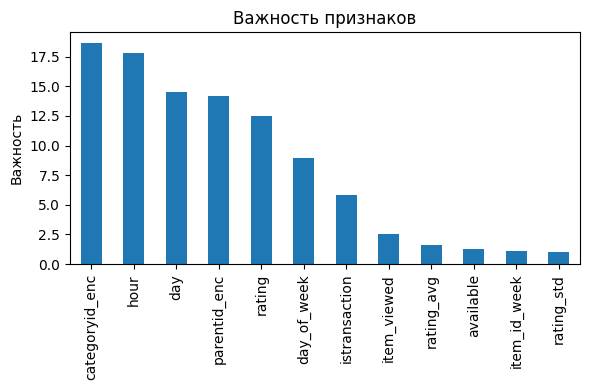

In [46]:
# Выведем диаграмму с оценкой влияния признаков на целевой
imp = pd.Series(cb_model.feature_importances_,
                features)

fig, ax = plt.subplots(figsize=(6,4))
imp.sort_values(ascending=False).plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность')
fig.tight_layout()

plt.savefig(os.path.join(ASSETS_DIR, 'cb_features_important'))

Наиболее важными для модели оказались категориальные признаки. Час и день взаимодействия с товарами оказывают сильное влияние на прогноз.

In [83]:
# Сохраним результат с другим названием
recommendations = candidates_to_rank[['user_id','item_id','rank']].copy()

# Сохраним результат в рекомендации
recommendations.to_parquet("../recsys/recommendations/recommendations.parquet", engine='pyarrow')

In [124]:
RUN_NAME = 'recsys_final_recs'

os.environ["MLFLOW_S3_ENDPOINT_URL"] = "https://storage.yandexcloud.net" 
os.environ["AWS_ACCESS_KEY_ID"] = os.getenv("AWS_ACCESS_KEY_ID") 
os.environ["AWS_SECRET_ACCESS_KEY"] = os.getenv("AWS_SECRET_ACCESS_KEY")


mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")

# настройки для логирования в MLFlow
pip_requirements = '../requirements.txt'
signature = mlflow.models.infer_signature(candidates_for_train[features], candidates_to_rank["cb_score"])
input_example = candidates_for_train[features][:10]

experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

parquet_file_path = "recommendations.parquet"
recommendations.to_parquet(parquet_file_path, engine='pyarrow')

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id
    
    mlflow.log_artifacts(ASSETS_DIR)

    model_info = mlflow.catboost.log_model( 
		cb_model=cb_model,
        artifact_path="models",
        registered_model_name=REGISTRY_MODEL_NAME,
        signature=signature,
        input_example=input_example,
        await_registration_for=60,
        pip_requirements=pip_requirements)
    
    mlflow.log_artifact(parquet_file_path)

Successfully registered model 'ranking_model'.
2025/01/28 21:00:44 INFO mlflow.tracking._model_registry.client: Waiting up to 60 seconds for model version to finish creation. Model name: ranking_model, version 1
Created version '1' of model 'ranking_model'.


## Оценка качества

Проверим оценку качества рекомендаций по умолчанию (топ-50 популярных) и персональных рекомендаций, полученных с помощью бустинговой модели по четырем метрикам: recall, precision, coverage, novelty.

In [52]:
# Загрузим рекомендации
top_k_pop_items = pd.read_parquet('../recsys/recommendations/top_popular.parquet')
cold_users = pd.read_csv('../data/cold_users.csv', index_col=False)

In [27]:
# Будем использовать холодных пользователей для оценки
user_list = list(cold_users['user_id'].unique())

events_cold = events[events['user_id'].isin(user_list)]
events_cold.info()

<class 'pandas.core.frame.DataFrame'>
Index: 228070 entries, 1039211 to 1323988
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   timestamp      228070 non-null  object 
 1   user_id        228070 non-null  int64  
 2   item_id        228070 non-null  int64  
 3   available      228070 non-null  int64  
 4   categoryid     228070 non-null  int64  
 5   parentid       228070 non-null  float64
 6   istransaction  228070 non-null  int64  
 7   day_of_week    228070 non-null  int64  
 8   day            228070 non-null  int64  
 9   hour           228070 non-null  int64  
 10  rating         228070 non-null  float64
 11  target         228070 non-null  int64  
dtypes: float64(2), int64(9), object(1)
memory usage: 22.6+ MB


In [54]:
# Посмотрим на полученные данные
events_cold.head()

,timestamp,user_id,item_id,available,categoryid,parentid,istransaction,day_of_week,day,hour,rating,target,user_id_enc,categoryid_enc,parentid_enc
1039211,2015-09-01 04:56:00,938236,374698,1,421,1424.0,0,1,1,4,0.077983,0,823800,272,224
1039212,2015-09-01 05:40:00,1016904,294319,0,209,293.0,0,1,1,5,0.008209,0,892914,134,51
1039213,2015-09-01 04:59:00,349857,277328,1,1051,955.0,0,1,1,4,0.077690,0,307207,676,155
1039214,2015-09-01 05:24:00,843815,42267,1,1589,1426.0,0,1,1,5,0.011140,0,740776,1025,225
1039216,2015-09-01 05:14:00,998325,145062,1,769,587.0,0,1,1,5,0.000293,0,876574,504,93


In [28]:
# Напомним, как выглядели рекомендации
top_k_pop_items.head()

,item_id,users,avg_rating,rank
71268,187946,2284,1.000000,1
2047,5411,1936,0.683964,2
140449,370653,1470,0.543242,3
112919,298009,1251,0.481091,4
36922,96924,1183,0.478452,5


In [29]:
# Добавим топ рекомендованных треков
cold_users_events_with_recs = events_cold.merge(top_k_pop_items, on="item_id", how="left") 

# Отберем данные, которые удалось получить из рекомендаций без пропусков
cold_user_items_no_avg_rating_idx = cold_users_events_with_recs["avg_rating"].isnull()
cold_user_recs = cold_users_events_with_recs[~cold_user_items_no_avg_rating_idx] \
                 [["user_id", "item_id", "avg_rating"]]

# Отберем данные, где рекомендации не были получены
cold_user_no_recs = cold_users_events_with_recs[cold_user_items_no_avg_rating_idx] \
                  [["user_id", "item_id", "avg_rating"]] 

In [33]:
# Посчитаем покрытие холодных пользователей рекомендациями
cold_users_hit_ratio = cold_users_events_with_recs.groupby("user_id").agg(hits=("avg_rating", lambda x: (~x.isnull()).mean()))

coverage_top = cold_users_hit_ratio[cold_users_hit_ratio != 0].mean().iat[0]

print(f"Доля пользователей без релевантных рекомендаций: {(cold_users_hit_ratio == 0).mean().iat[0]:.2f}")
print(f"Среднее покрытие пользователей: {cold_users_hit_ratio[cold_users_hit_ratio != 0].mean().iat[0]:.2f}")

Доля пользователей без релевантных рекомендаций: 0.97
Среднее покрытие пользователей: 0.84


In [31]:
# Зададим функцию для расчета recall
def calculate_not_null_mean(series: pd.Series) -> float:
    """Вычисляет среднее значение ненулевых значений"""
    return series.notnull().mean()

# Расчитаем среднее количество вхождений популярных треков для всех пользователей
recall_top_popular = cold_users_events_with_recs.groupby("user_id")["avg_rating"].apply(calculate_not_null_mean).mean()

print(f"Рекомендации топ-50, recall: {recall_top_popular:.5f}")

Рекомендации топ-50, recall: 0.02806


Результаты по метрике recall получились низкими. Далее расчитаем метрики для персональных рекомендаций.

In [73]:
# Загрузим рекомендации
final_recommendations = pd.read_parquet('../recsys/recommendations/recommendations.parquet', engine='pyarrow')

In [36]:
def process_events_recs_for_binary_metrics(events_train, events_test, recs, top_k=None):

    """
    Размечает пары <user_id, item_id> для общего множества пользователей признаками
    - gt (ground truth)
    - pr (prediction)
    top_k: расчёт ведётся только для top k-рекомендаций
    """
    
    events_test["gt"] = True
    common_users = set(events_test["user_id"]) & set(recs["user_id"])

    print(f"Common users: {len(common_users)}")
    
    events_for_common_users = events_test[events_test["user_id"].isin(common_users)].copy()
    recs_for_common_users = recs[recs["user_id"].isin(common_users)].copy()

    recs_for_common_users = recs_for_common_users.sort_values(["user_id", "score"], ascending=[True, False])

    events_for_common_users = events_for_common_users[events_for_common_users["item_id"].isin(
        events_train["item_id"].unique()
    )
    ]

    if top_k is not None:
        recs_for_common_users = recs_for_common_users.groupby("user_id").head(top_k)
    
    events_recs_common = events_for_common_users[["user_id", "item_id", "gt"]].merge(
        recs_for_common_users[["user_id", "item_id", "score"]], 
        on=["user_id", "item_id"], 
        how="outer",
    )    

    events_recs_common["gt"] = events_recs_common["gt"].fillna(False)
    events_recs_common["pr"] = ~events_recs_common["score"].isnull()
    
    events_recs_common["tp"] = events_recs_common["gt"] & events_recs_common["pr"]
    events_recs_common["fp"] = ~events_recs_common["gt"] & events_recs_common["pr"]
    events_recs_common["fn"] = events_recs_common["gt"] & ~events_recs_common["pr"]

    return events_recs_common

In [37]:
def compute_cls_metrics(events_recs_for_binary_metric):
    
    """Расчет precision и recall"""
    
    groupper = events_recs_for_binary_metric.groupby("user_id")

    # Computing precision
    precision = groupper["tp"].sum()/(groupper["tp"].sum()+groupper["fp"].sum())
    precision = precision.fillna(0).mean()
    
    # Computing recall
    recall = groupper["tp"].sum()/(groupper["tp"].sum()+groupper["fn"].sum())
    recall = recall.fillna(0).mean()

    return precision, recall

In [62]:
# Получим метрики для финальных рекомендаций
cb_events_recs_for_binary_metrics_5 = process_events_recs_for_binary_metrics(
    events_inference,
    events_test_2,
    final_recommendations.rename(columns={"cb_score": "score"}), 
    top_k=5)

cb_precision_5, cb_recall_5 = compute_cls_metrics(cb_events_recs_for_binary_metrics_5)

print(f"Итоговые рекомендации, precision: {cb_precision_5:.4f}, recall: {cb_recall_5:.4f}")

Common users: 3292
Итоговые рекомендации, precision: 0.2313, recall: 0.2605


In [63]:
# Расчёт покрытия по объектам
cov_final = final_recommendations['item_id'].nunique() / final_recommendations['user_id'].nunique()

print(f"Итоговые рекомендации, покрытие: {cov_final:.2f}") 

Итоговые рекомендации, покрытие: 6.26


In [64]:
# Разметим каждую рекомендацию признаком viewed
events_train["viewed"] = True

final_recommendations = final_recommendations.merge(events_train, on=["user_id", "item_id"], how="left")
final_recommendations["viewed"] = final_recommendations["viewed"].fillna(False).astype("bool")

In [65]:
# Проставим ранги
final_recommendations = final_recommendations.sort_values(by=["user_id", "cb_score"], ascending=[True, False])
final_recommendations["rank"] = final_recommendations.groupby("user_id").cumcount() + 1

In [66]:
# Посчитаем novelty по пользователям
novelty_5_final = (1-final_recommendations.query("rank <= 5").groupby("user_id")["viewed"].mean()).mean()

print(f"Итоговые рекомендации, novelty_5: {novelty_5_final:.3f}")

Итоговые рекомендации, novelty_5: 0.442


In [67]:
# Сделаем сводную таблицу по метрикам

popular_metrics = pd.Series([recall_top_popular, coverage_top], index=["recall_top_popular", "coverage"], name="top_popular")


final_recs_metrics = pd.Series([cb_precision_5, cb_recall_5,cov_final,novelty_5_final], 
                               index=["precision_5", "recall_5", "coverage", "novelty_5"],
                               name="final_recs")

metrics_df = pd.concat([popular_metrics, final_recs_metrics], axis=1).fillna(0)

metrics_df

,top_popular,final_recs
recall_top_popular,0.028058,0.000000
coverage,0.840535,6.261239
precision_5,0.000000,0.231280
recall_5,0.000000,0.260465
novelty_5,0.000000,0.441570


In [110]:
json_file_1 = metrics_df['top_popular'].to_json(orient='index')
with open('../data/top_popular_metrics.json', 'w') as f:
    f.write(json_file_1)

# Сохранение второго JSON файла (второй столбец как ключи)
json_file_2 = metrics_df['final_recs'].to_json(orient='index')
with open('../data/final_recs_metrics.json', 'w') as f:
    f.write(json_file_2)

In [111]:
# Теперь создадим словари для логирования
dict1 = metrics_df['top_popular'].to_dict()

# Создание второго словаря (метрики и их значения)
dict2 = metrics_df['final_recs'].to_dict()

In [125]:
RUN_NAME = 'recsys_final_metrics'

os.environ["MLFLOW_S3_ENDPOINT_URL"] = "https://storage.yandexcloud.net" 
os.environ["AWS_ACCESS_KEY_ID"] = os.getenv("AWS_ACCESS_KEY_ID") 
os.environ["AWS_SECRET_ACCESS_KEY"] = os.getenv("AWS_SECRET_ACCESS_KEY")


mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")

experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id
    
    mlflow.log_metrics(dict1)

In [116]:
os.environ["MLFLOW_S3_ENDPOINT_URL"] = "https://storage.yandexcloud.net" 
os.environ["AWS_ACCESS_KEY_ID"] = os.getenv("AWS_ACCESS_KEY_ID") 
os.environ["AWS_SECRET_ACCESS_KEY"] = os.getenv("AWS_SECRET_ACCESS_KEY")


mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")

experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id
    
    mlflow.log_metrics(dict2)

## Выводы

В датасете присутвует сильный дисбаланс таргета. Пользователи чаще всего просто проматривают товары и лишь в редких случая совершают целевое действие - добавляют товары в корзину. Возможно, с этим связаны низкие результаты по метрикам для полученных рекомендаций.